# Functions

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.model_selection import train_test_split

import os

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Code

In [2]:


def get_val_results():
   
    main_data = pd.read_excel('Validation_Interpolate_Median.xlsx')

  
    results_dir = "./Results_Validation"
    test_data_dir = "./ExcelsPrecision_Median"


    def format_parameters(param):
        return param.replace('_', '', 1)

    def format_frame(frame):
        frame_num = int(frame.split('_')[-1])
        return f"frame_{frame_num:06d}",frame_num


    filtered_data = main_data[main_data['Result'] == 1]


    combined_data = []

 
    for _, row in filtered_data.iterrows():
        video = row['Video']
        raw_frame = row['Frame']
        frame, frame_num = format_frame(raw_frame)
        params = format_parameters(row['Parameters'])

    
        image_path = os.path.join(results_dir, video, video, f"{frame}.png")
        test_data_path = os.path.join(test_data_dir, f"{video}_{params}_comapprox_post_processed_median.xlsx")

 
        if os.path.exists(test_data_path):
            test_data = pd.read_excel(test_data_path, index_col=0)  
            if frame_num in test_data.index:  
                test_row = test_data.loc[frame_num]
                combined_data.append({
                    'Image Path': image_path,
                    'Video': video,
                    'Frame': frame,
                    'Parameters': params,
                    'center_y(ccol)': test_row['center_y(ccol)'],
                    'center_x(crow)': test_row['center_x(crow)'],
                    'circle_radius': test_row['circle_radius']
                })
            else:
                print(f"Warning: Frame {frame_num} not found in {test_data_path}")
        else:
            print(f"Warning: Test data file not found for {test_data_path}")

    # Create DataFrame from combined data
    result_df = pd.DataFrame(combined_data)

    # Save to Excel
    output_path = "combined_results2.xlsx"
    result_df.to_excel(output_path, index=False)
    print(f"Combined results saved to {output_path}")


# Test

In [3]:

def build_autoencoder(input_shape=(256, 256, 1)):
   
    input_img = Input(shape=input_shape, name='input_image')


    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Flatten(name='encoded_features')(x)


    radius_pred = Dense(1, activation='linear', name='radius_output')(encoded)


    x = Dense(1024, activation='relu')(encoded)
    x = Reshape((4, 4, 64))(x)


    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)             
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)               
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)              
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)              
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)               
    x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='image_output')(x)
    # print("image shape:", decoded.shape)
    
    autoencoder = Model(inputs=input_img, outputs=[decoded, radius_pred], name='autoencoder')




  
    autoencoder = Model(inputs=input_img, outputs=[decoded, radius_pred], name='autoencoder')
    return autoencoder


def train_autoencoder(autoencoder, x_train, radii_train, x_val, radii_val, epochs=50, batch_size=32):
    autoencoder.compile(
        optimizer='adam',
        loss={'image_output': 'mse', 'radius_output': 'mse'}
    )

   
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

   
    history = autoencoder.fit(
        x_train,
        {'image_output': x_train, 'radius_output': radii_train},
        validation_data=(x_val, {'image_output': x_val, 'radius_output': radii_val}),
        epochs=50,
        batch_size=32
    )


    autoencoder.summary()

    return history



In [ ]:



df = pd.read_excel('combined_results.xlsx')

image_paths = df['Image Path'].tolist()  
radii = df['circle_radius'].values      


img_height, img_width = 256, 256  
images = []

for path in image_paths:
  
    img = load_img(path, target_size=(img_height, img_width), color_mode='grayscale')
    img_array = img_to_array(img) / 255.0  
    images.append(img_array)


images = np.array(images)  # Shape: (num_samples, img_height, img_width, 1)
radii = radii.reshape(-1, 1)  # Shape: (num_samples, 1)


x_train, x_val, radii_train, radii_val = train_test_split(
    images, radii, test_size=0.2, random_state=42
)


autoencoder = build_autoencoder(input_shape=(img_height, img_width, 1))
history = train_autoencoder(autoencoder, x_train, radii_train, x_val, radii_val, epochs=50, batch_size=32)


# autoencoder.save('diffraction_autoencoder_crow.h5')


test_images = x_val[:10]  
reconstructed_images, predicted_radii = autoencoder.predict(test_images)


print("Predicted Radii:", predicted_radii.flatten())


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - image_output_loss: 0.1406 - loss: 721.9047 - radius_output_loss: 716.5327 - val_image_output_loss: 0.1375 - val_loss: 58.6434 - val_radius_output_loss: 55.0959
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - image_output_loss: 0.1407 - loss: 60.4605 - radius_output_loss: 61.0886 - val_image_output_loss: 0.1281 - val_loss: 84.2105 - val_radius_output_loss: 87.5152
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - image_output_loss: 0.1088 - loss: 49.0918 - radius_output_loss: 49.0035 - val_image_output_loss: 0.0517 - val_loss: 71.2159 - val_radius_output_loss: 67.4245
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - image_output_loss: 0.0435 - loss: 46.3137 - radius_output_loss: 45.8412 - val_image_output_loss: 0.0308 - val_loss: 23.6237 - val_radius_output_loss: 25.1787
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - image_output_loss: 0.0299 - loss: 24.4067 - radius_output_loss: 24.0621 - val_image_output_loss: 0.0288 - val_loss: 

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


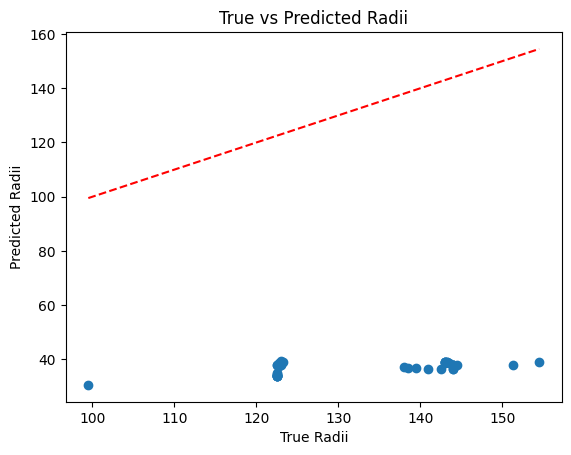

In [ ]:
df = pd.read_excel('combined_results.xlsx')


image_paths = df['Image Path'].tolist()  
radii = df['center_x(crow)'].values       

img_height, img_width = 256, 256 #FIXED DImensions
images = []

for path in image_paths:
   
    img = load_img(path, target_size=(img_height, img_width), color_mode='grayscale')
    img_array = img_to_array(img) / 255.0  
    images.append(img_array)


images = np.array(images)  # Shape: (num_samples, img_height, img_width, 1)
radii = radii.reshape(-1, 1)  # Shape: (num_samples, 1)


x_train, x_val, radii_train, radii_val = train_test_split(
    images, radii, test_size=0.2, random_state=42
)

# autoencoder = load_model('diffraction_autoencoder.h5', custom_objects={'mse': MeanSquaredError()})
test_images = x_val
reconstructed_images, predicted_radii = autoencoder.predict(test_images)


plt.scatter(radii_val, predicted_radii)
plt.plot([radii_val.min(), radii_val.max()], [radii_val.min(), radii_val.max()], color='r', linestyle='--')
plt.xlabel('True Radii')
plt.ylabel('Predicted Radii')
plt.title('True vs Predicted Radii')
plt.show()


# Loading the images of Test_Validation

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from PIL import Image, ImageOps
import os
from pathlib import Path

In [3]:
os.makedirs('tmp',exist_ok=True)

In [4]:
def preprocess_images(path):

    img_height, img_width = 256, 256
    img = load_img(path, target_size=(img_height, img_width), color_mode='grayscale')
    img_array = img_to_array(img) / 255.0  


    fig_dpi = 80  
    fig_width, fig_height = 8, 6  

    fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=fig_dpi)

    ax.imshow(img_array, cmap='gray')

    plt.savefig('tmp/figure_with_border.png', dpi=fig_dpi)

    # plt.show()
    img = load_img('tmp/figure_with_border.png', target_size=(img_height, img_width), color_mode='grayscale')
    result = img_to_array(img) / 255.0  
    # os.remove('tmp/figure_with_border.png')
    return result


In [5]:
def draw_circle(file_path,path,radius,ccol,crow,filename):
        print(file_path)
        image=cv2.imread(file_path,cv2.IMREAD_GRAYSCALE)
        fig, ax = plt.subplots()
        ax.imshow(image, cmap='gray')
        circle_center=(ccol,crow)
        circle = patches.Circle(circle_center, radius, edgecolor='black', facecolor='none', linewidth=1)
        ax.add_patch(circle)

        cross_size = 10
        ax.plot([circle_center[0] - cross_size, circle_center[0] + cross_size], 
                [circle_center[1], circle_center[1]], color='white', linewidth=2) 
        ax.plot([circle_center[0], circle_center[0]], 
                [circle_center[1] - cross_size, circle_center[1] + cross_size], color='white', linewidth=2) 
        fig.savefig(os.path.join(path, f"result_{filename}"))
        print(os.path.join(path, f"result_{filename}"))
        plt.cla()
        plt.close(fig)
        plt.close('all')
        del fig,ax

In [6]:
def process_images(image,autoencoder_radius,autoencoder_ccol,autoencoder_crow):
    image = np.expand_dims(image, axis=0)

    image_tmp,radius=autoencoder_radius.predict(image)
    image_tmp_2,ccol=autoencoder_ccol.predict(image)
    image_tmp_3,crow=autoencoder_crow.predict(image)
    del image_tmp, image_tmp_2,image_tmp_3
    return radius[0][0],ccol[0][0],crow[0][0]

In [7]:
def find_circles(test_number,result_path,input_path,excel_path,autoencoder_radius,autoencoder_ccol,autoencoder_crow):
    output_path=Path(input_path)
    output_path.mkdir(parents=True, exist_ok=True)
    Path(result_path).mkdir(parents=True, exist_ok=True)
    Path(excel_path).mkdir(parents=True, exist_ok=True)

    excel_path+=f'/AutoencodersNoNCenter{test_number}.xlsx'

    filenames=os.listdir(output_path)

    df_list=[]
    i=0
    for filename in filenames:
        file_path = os.path.join(output_path, filename)
        image=cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        
        image=preprocess_images(file_path)
        # plt.imshow(image)
        # plt.show()
        # print(image.shape)
        # print(file_path)
        
        radius,ccol,crow = process_images(image,autoencoder_radius,autoencoder_ccol,autoencoder_crow)

        dfPrevData = pd.read_excel(f'Testing_ideas/ExcelsTesting/Video{test_number}_37_1_hough_cropped_obj_2.xlsx')
        ccol = dfPrevData['center_y(ccol)'].values[i]
        crow = dfPrevData['center_x(crow)'].values[i]

        # print(f'radius {radius} ccol {ccol} crow {crow}')
        draw_circle(file_path,result_path,radius,ccol,crow,filename)


        new_data = pd.DataFrame({
        'center_y(ccol)': [ccol],
        'center_x(crow)': [crow],
        'circle_radius': [radius]
        })

        df_list.append(new_data)
        # if(i==999):
        #     break
        i+=1

    df = pd.concat(df_list, ignore_index=True)
    df.to_excel(excel_path)
        
        

In [ ]:
# autoencoder_radius = load_model('diffraction_autoencoder.h5', custom_objects={'mse': MeanSquaredError()})
# autoencoder_ccol = load_model('diffraction_autoencoder_ccol.h5', custom_objects={'mse': MeanSquaredError()})
# autoencoder_crow = load_model('diffraction_autoencoder_crow.h5', custom_objects={'mse': MeanSquaredError()})
# test='large'
# params={
#     'test_number':test,
#     'result_path':f"Results_Validation/{test}/cropped_object_1/" + f"_Results_bw_Video{test}",
#     'input_path':f'Results_Validation/Video{test}/cropped_object_1',
#     'excel_path':f'ExcelsTesting/Autoencoders/Video{test}_cropped_object_1',
#     'autoencoder_radius':autoencoder_radius,
#     'autoencoder_ccol':autoencoder_ccol,
#     'autoencoder_crow':autoencoder_crow

#     }
# find_circles(**params)


In [9]:
autoencoder_radius = load_model('diffraction_autoencoder.h5', custom_objects={'mse': MeanSquaredError()})
autoencoder_ccol = load_model('diffraction_autoencoder_ccol.h5', custom_objects={'mse': MeanSquaredError()})
autoencoder_crow = load_model('diffraction_autoencoder_crow.h5', custom_objects={'mse': MeanSquaredError()})
test='large'
params={
    'test_number':test,
    'result_path':f"Results_Validation/{test}/cropped_object_2/" + f"_Results_bw_Video{test}",
    'input_path':f'Results_Validation/Video{test}/cropped_object_2',
    'excel_path':f'ExcelsTesting/Autoencoders/Video{test}_cropped_object_2',
    'autoencoder_radius':autoencoder_radius,
    'autoencoder_ccol':autoencoder_ccol,
    'autoencoder_crow':autoencoder_crow

    }
find_circles(**params)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
Results_Validation\Videolarge\cropped_object_2\frame_000000.png_object2.png
Results_Validation/large/cropped_object_2/_Results_bw_Videolarge\result_frame_000000.png_object2.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Results_Validation\Videolarge\cropped_object_2\frame_000001.png_object2.png
Results_Validation/large/cropped_object_2/_Results_bw_Videolarge\result_frame_000001.png_object2.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Results_Validation\Videolarge\cropped_object_2\frame_000002.png_object2.png
Results_Validation/large/cropped_object_2/_Results_bw_Videolarge\result_frame_000002.png_object2.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Results_Va

In [10]:
# autoencoder_radius = load_model('diffraction_autoencoder.h5', custom_objects={'mse': MeanSquaredError()})
# autoencoder_ccol = load_model('diffraction_autoencoder_ccol.h5', custom_objects={'mse': MeanSquaredError()})
# autoencoder_crow = load_model('diffraction_autoencoder_crow.h5', custom_objects={'mse': MeanSquaredError()})
# test=9
# params={
#     'test_number':test,
#     'result_path':f"Results_Validation/{test}/" + f"_Results_bw_Video{test}",
#     'input_path':f'Results_Validation/Video{test}/Video{test}',
#     'excel_path':f'ExcelsTesting/Autoencoders/Video{test}',
#     'autoencoder_radius':autoencoder_radius,
#     'autoencoder_ccol':autoencoder_ccol,
#     'autoencoder_crow':autoencoder_crow

#     }
# find_circles(**params)


In [11]:
# autoencoder_radius = load_model('diffraction_autoencoder.h5', custom_objects={'mse': MeanSquaredError()})
# autoencoder_ccol = load_model('diffraction_autoencoder_ccol.h5', custom_objects={'mse': MeanSquaredError()})
# autoencoder_crow = load_model('diffraction_autoencoder_crow.h5', custom_objects={'mse': MeanSquaredError()})

# for test in range(1,11):
#     params={
#         'test_number':test,
#         'result_path':f"Results_Validation/{test}/" + f"_Results_bw_Video{test}",
#         'input_path':f'Results_Validation/Video{test}/Video{test}',
#         'excel_path':f'ExcelsTesting/Autoencoders/Video{test}',
#         'autoencoder_radius':autoencoder_radius,
#         'autoencoder_ccol':autoencoder_ccol,
#         'autoencoder_crow':autoencoder_crow

#     }
#     try:
#         print(params)
#         find_circles(**params)
#     except Exception as e:
#         print(e)
#         continue
